In [3]:
import requests
import numpy as np

LLAMAFILER_API = "http://localhost:8080"

def make_embedding(content: str):
    response = requests.post(LLAMAFILER_API + "/embedding", json={"content": content})
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Get the "embedding" field and convert it to a numpy array
        embedding = np.array(data["embedding"])

        return embedding
    else:
        print("Failed to retrieve data")
        raise AssertionError("Resposta inválida")

In [ ]:
import json
import numpy as np
import pandas as pd
import pickle

def create_embeds():
    SENTIMENT_INOFF = 0
    SENTIMENT_OFF = 1

    def load_json(path):
        with open(path, "r") as f:
            return json.load(f)

    sentiment_inoff_rows = load_json("../0_SyntheticDatasetMaker/output_processed.json")
    sentiment_off_rows = load_json("../Dataset/OffensiveTweets.json")

    df = pd.DataFrame(columns=[f"d{i}" for i in range(0, 384)])
    df.insert(0, "sentiment", [])
    df.insert(0, "content", [])

    for i, tweet in enumerate(sentiment_inoff_rows):
        embedding = make_embedding(tweet)
        df.loc[-1] = np.concatenate(([tweet, SENTIMENT_INOFF], embedding)) # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index

    for i, tweet in enumerate(sentiment_off_rows):
        embedding = make_embedding(tweet)
        df.loc[-1] = np.concatenate(([tweet, SENTIMENT_OFF], embedding)) # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index

    with open("./embeddings.dat", "wb") as f:
        pickle.dump(df, f)
    
    return df

df = create_embeds()

Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       225
           1       0.98      0.99      0.98       786

    accuracy                           0.97      1011
   macro avg       0.96      0.96      0.96      1011
weighted avg       0.97      0.97      0.97      1011

[[209  16]
 [ 11 775]]

Decision Tree:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       225
           1       0.94      0.93      0.94       786

    accuracy                           0.91      1011
   macro avg       0.86      0.87      0.86      1011
weighted avg       0.91      0.91      0.91      1011

[[182  43]
 [ 53 733]]

Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       225
           1       0.97      0.98      0.98       786

    accuracy                           0.97      1011
   macro avg       0.96      

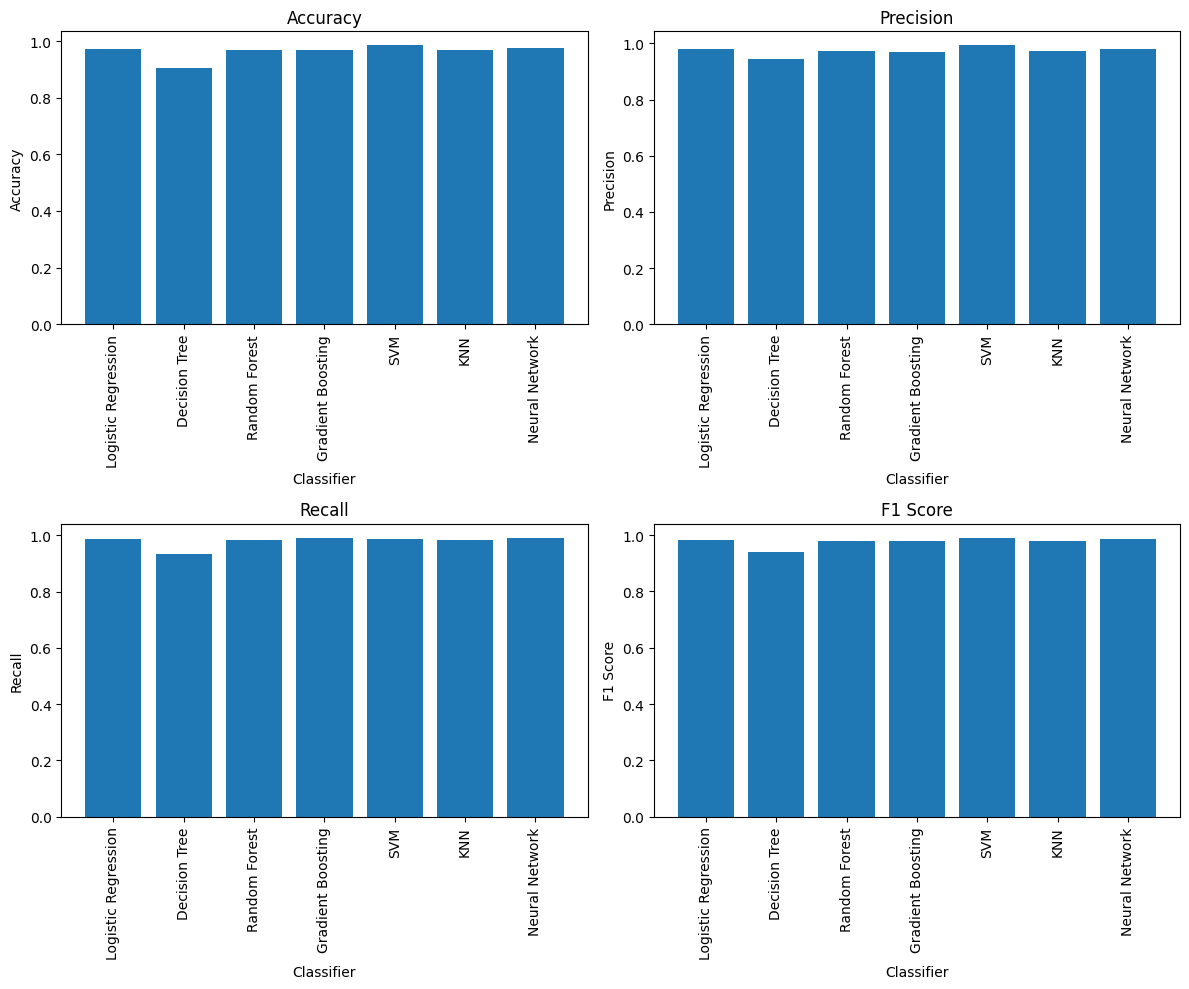

In [6]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pickle

f = open("./embeddings.dat","rb")
df = pickle.load(f)
f.close()

X = df.iloc[:, 2:] # dataframe contendo as colunas após a segunda
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Define the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(10,))
}

# Train and test the classifiers
results = {
    'Accuracy': {},
    'Precision': {},
    'Recall': {},
    'F1 Score': {}
}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train.values.ravel())

    with open(f"./models/{name}.pickle", "wb") as mf:
        pickle.dump(clf, mf)
        
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='1')
    recall = recall_score(y_test, y_pred, pos_label='1')
    f1 = f1_score(y_test, y_pred, pos_label='1')
    results['Accuracy'][name] = accuracy
    results['Precision'][name] = precision
    results['Recall'][name] = recall
    results['F1 Score'][name] = f1
    print(f"{name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print()

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].bar(results['Accuracy'].keys(), results['Accuracy'].values())
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Classifier')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].tick_params(axis='x', rotation=90)

axs[0, 1].bar(results['Precision'].keys(), results['Precision'].values())
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Classifier')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].tick_params(axis='x', rotation=90)

axs[1, 0].bar(results['Recall'].keys(), results['Recall'].values())
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Classifier')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].tick_params(axis='x', rotation=90)

axs[1, 1].bar(results['F1 Score'].keys(), results['F1 Score'].values())
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_xlabel('Classifier')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig('classifier_comparison.png')

In [9]:
import pickle
import os
import pandas as pd

def classify(content: str):
    results = {}
    
    for filePath in os.listdir("./models"):
        if not filePath.endswith(".pickle"):
            continue

        embeddings = make_embedding(content)

        X = pd.DataFrame(columns=[f"d{i}" for i in range(0, 384)])
        X.loc[0] = embeddings;


        with open(f"./models/{filePath}", "rb") as f:
            model = pickle.load(f)
            
            y = model.predict(X)[0]
            results[filePath.replace(".pickle", "")] = str(y);

    return results

classify("I love strawberries")
classify("Artificial Intelligence is bad and should be exterminated")
classify("Test")

{'SVM': '0',
 'Gradient Boosting': '0',
 'Neural Network': '0',
 'Logistic Regression': '0',
 'Random Forest': '0',
 'Decision Tree': '0',
 'KNN': '0'}